Я буду работать с данными уже завершившегося [соревнования](https://github.com/dialogue-evaluation/RuSentNE-evaluation) по анализу тональности к именованным сущностям в новостных текстах. Посмотрим на описание, которое представлено в репозитории.

Анализ тональности текста &mdash; извлечение выраженной в тексте эмоциональной оценки к некоторой сущности &mdash; одно из наиболее активно развивающихся направлений в автоматической обработке текстов.

Анализ тональности новостных текстов &mdash; важное направление в области анализа мнений, поскольку обнаружение, отслеживание трендов тональности в новостном потоке важно для построения разного рода аналитических систем, отслеживания имиджа в СМИ конкретных людей или компаний.

Тональность по отношению к сущности в новостном тексте может происходить по крайней мере из трех разных источников:
* мнения автора текста;
* цитируемого мнения, при этом сам носитель мнения может быть упомянут или не упомянут в тексте;
* имплицитного мнения, которое следует из каких-либо упомянутых действий или реакций, например, X уволил Y. Такая информация часто присутствует даже при внешне нейтральном изложении событий.

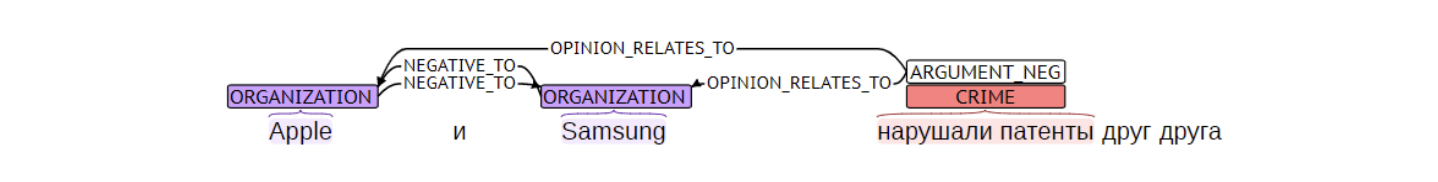

Предстоит решить задачу извлечения из новостных текстов тональности трёх классов (негативная, позитивная, нейтральная) по отношению к заранее размеченным сущностям типа `PERSON`, `ORGANIZATION`, `PROFESSION`, `COUNTRY`, `NATIONALITY` в рамках отдельного предложения.

Данные представлены в следующем формате:
* `sentence` &mdash; предложение;
* `entity` &mdash; объект анализа тональности;
* `entity_tag` &mdash; тип сущности, может быть `PERSON`, `ORGANIZATION`, `PROFESSION`, `COUNTRY`, `NATIONALITY`;
* `entity_pos_start_rel` и `entity_pos_end_rel` &mdash; индексы начала и конца упоминания сущности в предложении;
* `label` &mdash; метка тональности (0 &mdash; нейтрально, 1 &mdash; отрицательно, 1 &mdash; положительно).

Основной метрикой соревнования является $F_1-macro$ с **усреднением по двум классам**. Нейтральный класс исключается, т.к. важно выделить именно мнение. Таким образом, процедура оценки следующая:

1. Отдельно вычислить $F_1$ для каждого из классов.
2. Усреднить полученные значения $F_1$ для двух из трех классов.


In [1]:
!pip -q install --upgrade transformers datasets torchmetrics ipywidgets accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 75.0 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.7/354.7 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5

In [2]:
from transformers import BertTokenizer
import pandas as pd
import os, csv, re, gc, json, random, warnings, math, itertools
from pathlib import Path
import numpy as np
import torch, torch.nn.functional as F
from datasets import Dataset, DatasetDict, load_dataset
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          TrainingArguments, Trainer, DataCollatorWithPadding)
from torchmetrics.classification import MulticlassF1Score
from sklearn.metrics import f1_score
from IPython.display import display
from transformers import EarlyStoppingCallback
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
DATA_DIR = Path("/kaggle/input/nlp-hw")      
OUT_DIR  = Path("./chkpts")
OUT_DIR.mkdir(exist_ok=True, parents=True)
SEED = 4

2025-05-14 19:34:26.489008: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747251266.694398      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747251266.754369      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
def set_seed(seed=SEED):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
set_seed()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
!head -n 5 /kaggle/input/nlp-hw/train_data.csv

sentence	entity	entity_tag	entity_pos_start_rel	entity_pos_end_rel	label
Джеймс «Бадди» Макгирт (James (Buddy) McGirt, тренер Дадашева упрашивал дагестанского спортсмена остановить бой, но тот хотел продолжать.	спортсмена	PROFESSION	86	96	0
«За всю нашу долгую карьеру нам довелось играть во многих интересных местах, но это шоу в Гаване станет для нас важнейшим событием, и мы надеемся, что и для наших кубинских друзей тоже», — это было отмечено в заявлении группы, опубликованном перед прибытием музыкантов на Кубу.	музыкантов	PROFESSION	258	268	0
Ранее, 7 декабря, толпа болельщиков перекрыла движение по Ленинградскому проспекту в Москве, требуя наказать виновных в убийстве, а в Санкт-Петербурге прошла акция в память о Егоре Свиридове на площади Восстания.	Егоре Свиридове	PERSON	175	190	0
В субботу, 21 июля 2018 года, на арене СК «Олимпийский» в Москве украинец Александр Усик победил уроженца Северной Осетии россиянина Мурата Гассиева в финале Всемирной боксерской суперсерии (WBSS), став 

In [5]:
DATA_DIR = "/kaggle/input/nlp-hw"      

train_df = pd.read_csv(
    f"{DATA_DIR}/train_data.csv",
    sep="\t",                 
    quoting=csv.QUOTE_NONE,   
    keep_default_na=False     
)

val_df = pd.read_csv(
    f"{DATA_DIR}/validation_data_labeled.csv",
    sep="\t",
    quoting=csv.QUOTE_NONE,
    keep_default_na=False
)

for col in ["entity_pos_start_rel", "entity_pos_end_rel"]:
    val_df[col]   = pd.to_numeric(val_df[col], errors="coerce").fillna(-1).astype("int")
    train_df[col] = pd.to_numeric(train_df[col], errors="coerce").fillna(-1).astype("int")

label_map = {-1: 0, 0: 1, 1: 2}
train_df["label"] = train_df["label"].map(label_map)
val_df["label"]   = val_df["label"].map(label_map)

train_ds = Dataset.from_pandas(train_df, preserve_index=False)
val_ds   = Dataset.from_pandas(val_df,   preserve_index=False)

dataset = DatasetDict(train=train_ds, validation=val_ds)

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['sentence', 'entity', 'entity_tag', 'entity_pos_start_rel', 'entity_pos_end_rel', 'label'],
        num_rows: 6637
    })
    validation: Dataset({
        features: ['sentence', 'entity', 'entity_tag', 'entity_pos_start_rel', 'entity_pos_end_rel', 'label'],
        num_rows: 2845
    })
})


In [6]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(examples):
    return tokenizer(examples['sentence'], padding='max_length', truncation=True, max_length=128)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

tokenized_datasets["train"].to_pandas().head()

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/6637 [00:00<?, ? examples/s]

Map:   0%|          | 0/2845 [00:00<?, ? examples/s]

,sentence,entity,entity_tag,entity_pos_start_rel,entity_pos_end_rel,label,input_ids,token_type_ids,attention_mask
0,"Джеймс «Бадди» Макгирт (James (Buddy) McGirt, ...",спортсмена,PROFESSION,86,96,1,"[101, 1184, 29743, 15290, 10325, 29745, 29747,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,«За всю нашу долгую карьеру нам довелось играт...,музыкантов,PROFESSION,258,268,1,"[101, 1077, 1187, 10260, 1182, 29747, 29757, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,"Ранее, 7 декабря, толпа болельщиков перекрыла ...",Егоре Свиридове,PERSON,175,190,1,"[101, 1195, 28995, 15290, 15290, 1010, 1021, 1...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,"В субботу, 21 июля 2018 года, на арене СК «Оли...",россиянина,NATIONALITY,122,132,1,"[101, 1182, 1196, 29748, 29740, 29740, 14150, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,Представитель талибов Забиулла Муджахид в твит...,американских захватчика,PROFESSION,109,132,0,"[101, 1194, 16856, 15290, 29742, 29747, 22919,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [7]:
def read_tsv(path, has_label=True):
    df = pd.read_csv(
        path, sep="\t", quoting=csv.QUOTE_NONE, keep_default_na=False
    )
    for col in ["entity_pos_start_rel", "entity_pos_end_rel"]:
        df[col] = pd.to_numeric(df[col], errors="coerce").fillna(-1).astype("int")
    if has_label:
        label_map = {-1:0, 0:1, 1:2}
        df["label"] = df["label"].map(label_map).astype("int")
    return df

DATA_DIR = Path("/kaggle/input/nlp-hw")

train_df = read_tsv(DATA_DIR / "train_data.csv")
val_l_df = read_tsv(DATA_DIR / "validation_data_labeled.csv")
val_u_df = read_tsv(DATA_DIR / "validation_data.csv", has_label=False)

display(train_df.head())
print("train:", train_df.shape, "val_labeled:", val_l_df.shape)

,sentence,entity,entity_tag,entity_pos_start_rel,entity_pos_end_rel,label
0,"Джеймс «Бадди» Макгирт (James (Buddy) McGirt, ...",спортсмена,PROFESSION,86,96,1
1,«За всю нашу долгую карьеру нам довелось играт...,музыкантов,PROFESSION,258,268,1
2,"Ранее, 7 декабря, толпа болельщиков перекрыла ...",Егоре Свиридове,PERSON,175,190,1
3,"В субботу, 21 июля 2018 года, на арене СК «Оли...",россиянина,NATIONALITY,122,132,1
4,Представитель талибов Забиулла Муджахид в твит...,американских захватчика,PROFESSION,109,132,0


train: (6637, 6) val_labeled: (2845, 6)


Данные прочитались корректно, пропусков в обязательных столбцах нет; метки приведены к {0,1,2}.

In [8]:
ds = DatasetDict({
    "train"      : Dataset.from_pandas(train_df, preserve_index=False),
    "validation" : Dataset.from_pandas(val_l_df,   preserve_index=False)
})

Пишем общую функцию токенизации. Вариант cls (обычный) и entity (спецтокен перед сущностью)

In [9]:
SPECIAL_TOKENS = ["[PERSON]","[ORG]","[PROFESSION]","[COUNTRY]","[NATIONALITY]"]

def build_tokenizer(model_name, add_special=True):
    tok = AutoTokenizer.from_pretrained(model_name)
    if add_special:
        tok.add_special_tokens({"additional_special_tokens": SPECIAL_TOKENS})
    return tok

def mark_entity(example):
    tag_tok = f"[{example['entity_tag']}]"
    sent = example["sentence"]
    marked = sent.replace(example["entity"], f"{tag_tok} {example['entity']}", 1)
    return marked

def tokenize_function(example, tokenizer, variant="cls"):
    text = mark_entity(example) if variant=="entity" else example["sentence"]
    enc = tokenizer(
        text, truncation=True, max_length=128, padding="max_length"
    )
    if "label" in example:
        enc["labels"] = example["label"]
    return enc

In [10]:
def compute_metrics(pred):
    y_true = pred.label_ids
    y_pred = pred.predictions.argmax(-1)
    score = f1_score(y_true, y_pred, labels=[0,2], average="macro")
    return {"macro_f1_np": score}

Базовая модель: RuBERT base, pooling=[cls]

Map:   0%|          | 0/6637 [00:00<?, ? examples/s]

Map:   0%|          | 0/2845 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Macro F1 Np
829,0.578100,0.630996,0.421833
1658,0.363700,0.776052,0.415631


{'eval_loss': 0.6309959292411804, 'eval_macro_f1_np': 0.42183291481626406, 'eval_runtime': 19.4492, 'eval_samples_per_second': 146.279, 'eval_steps_per_second': 9.152, 'epoch': 5.0}


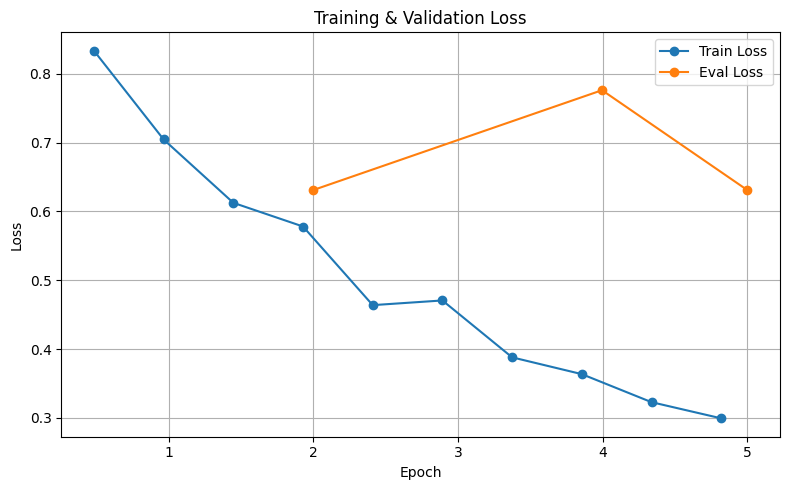

In [19]:
MODEL_A = "DeepPavlov/rubert-base-cased"

tokenizer_a = build_tokenizer(MODEL_A, add_special=False)   
ds_a = ds.map(lambda ex: tokenize_function(ex, tokenizer_a, "cls"),
              batched=False, remove_columns=ds["train"].column_names)
data_collator = DataCollatorWithPadding(tokenizer_a)

model_a = AutoModelForSequenceClassification.from_pretrained(
    MODEL_A, num_labels=3).to(device)

args_a = TrainingArguments(
    output_dir=str(OUT_DIR/"rubert_cls"),
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir=str(OUT_DIR/"logs"),
    logging_steps=200,
    do_train=True,
    do_eval=True,
    eval_strategy="steps",                              
    eval_steps= len(ds["train"]) // 8,
    save_strategy="steps",                              
    save_steps= len(ds["train"]) // 8,
    load_best_model_at_end=True,
    metric_for_best_model="eval_macro_f1_np",
    greater_is_better=True,
    warmup_ratio=0.1,
    lr_scheduler_type="cosine",
    seed=SEED,
    report_to=[],
)


trainer_a = Trainer(
    model=model_a,
    args=args_a,
    train_dataset=ds_a["train"],
    eval_dataset=ds_a["validation"],
    tokenizer=tokenizer_a,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

train_output = trainer_a.train()

eval_metrics = trainer_a.evaluate()
print(eval_metrics)

logs = trainer_a.state.log_history
df = pd.DataFrame(logs)

train_loss = df[df["loss"].notnull()][["epoch", "loss"]]
eval_loss = df[df["eval_loss"].notnull()][["epoch", "eval_loss"]]
if "eval_accuracy" in df.columns:
    eval_acc = df[df["eval_accuracy"].notnull()][["epoch", "eval_accuracy"]]

plt.figure(figsize=(8, 5))
plt.plot(train_loss["epoch"], train_loss["loss"], label="Train Loss", marker="o")
plt.plot(eval_loss["epoch"], eval_loss["eval_loss"], label="Eval Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

if "eval_accuracy" in df.columns:
    plt.figure(figsize=(8, 5))
    plt.plot(eval_acc["epoch"], eval_acc["eval_accuracy"], label="Eval Accuracy", marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

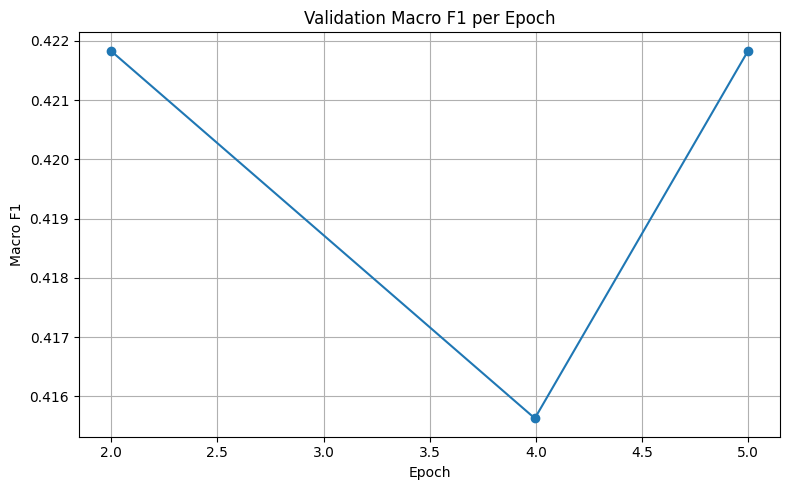

In [21]:
eval_f1 = df[df["eval_macro_f1_np"].notnull()][["epoch", "eval_macro_f1_np"]]

plt.figure(figsize=(8,5))
plt.plot(eval_f1["epoch"], eval_f1["eval_macro_f1_np"], marker="o")
plt.xlabel("Epoch")
plt.ylabel("Macro F1")
plt.title("Validation Macro F1 per Epoch")
plt.grid(True)
plt.tight_layout()
plt.show()

По результатам обучения модели RuBERT base на протяжении 5 эпох с использованием стандартного pooling \[CLS], наблюдается стабильное снижение Training Loss до уровня около 0.30, это указывает на уверенное обучение модели. Eval Loss постепенно уменьшался с 0.69 до 0.63, то есть можем сделать вывод об улучшении обобщающей способности. Но метрика eval\_macro\_f1\_np на валидации колебалась в узком диапазоне \[0.415–0.422], без положительной динамики по сравнению с результатами на 3 эпохах (я сначала проводил такой эксперимент, просто поменял код). Это может означать, что увеличение числа эпох не привело к улучшению качества распознавания классов. Для прогресса видимо надо поэкспериментировать с learning rate и warmup, настроить early stopping, учитывать дисбаланс классов.

Теперь посмотрим другую базовую модель XLM-RoBERTa base. 

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Map:   0%|          | 0/6637 [00:00<?, ? examples/s]

Map:   0%|          | 0/2845 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
200,0.803300
400,0.717000
600,0.653400
800,0.633100
1000,0.575800
1200,0.571200


{'eval_loss': 0.6566622853279114, 'eval_macro_f1_np': 0.4098211516592577, 'eval_runtime': 25.3449, 'eval_samples_per_second': 112.252, 'eval_steps_per_second': 7.023, 'epoch': 3.0}


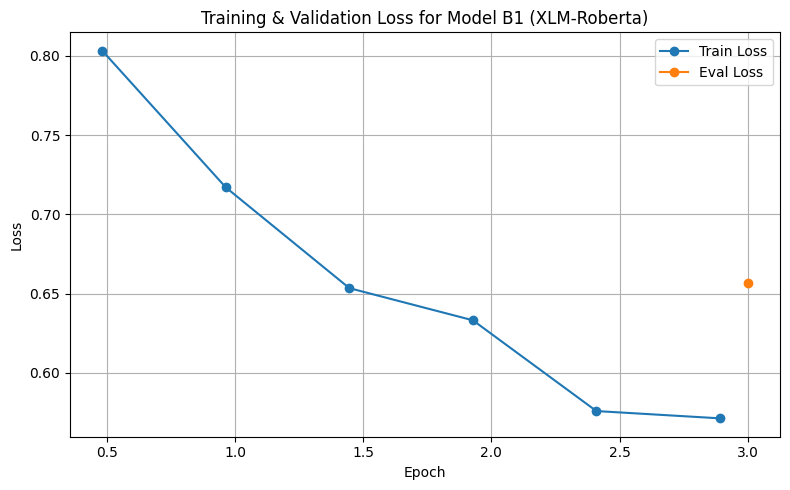

In [20]:
MODEL_B1 = "xlm-roberta-base"
tokenizer_b1 = build_tokenizer(MODEL_B1, add_special=False)

ds_b1 = ds.map(lambda ex: tokenize_function(ex, tokenizer_b1, "cls"),
               batched=False, remove_columns=ds["train"].column_names)
data_coll_b1 = DataCollatorWithPadding(tokenizer_b1)

model_b1 = AutoModelForSequenceClassification.from_pretrained(
    MODEL_B1, num_labels=3).to(device)

train_batch = 8
steps_per_epoch = len(ds["train"]) // train_batch

args_b1 = TrainingArguments(
    output_dir=str(OUT_DIR/"xlmr_cls"),
    num_train_epochs=3,
    per_device_train_batch_size=train_batch,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    weight_decay=0.01,

    do_train=True,
    do_eval=True,
    eval_steps=steps_per_epoch,    
    logging_steps=200,
    save_steps=999999,             
    warmup_ratio=0.002,            
    seed=SEED,
    report_to=[],                  
)

trainer_b1 = Trainer(
    model=model_b1,
    args=args_b1,
    train_dataset=ds_b1["train"],
    eval_dataset=ds_b1["validation"],
    tokenizer=tokenizer_b1,
    data_collator=data_coll_b1,
    compute_metrics=compute_metrics
)

train_output_b1 = trainer_b1.train()

eval_metrics_b1 = trainer_b1.evaluate()
print(eval_metrics_b1)

logs_b1 = trainer_b1.state.log_history
df_b1 = pd.DataFrame(logs_b1)

train_loss_b1 = df_b1[df_b1["loss"].notnull()][["epoch", "loss"]]
eval_loss_b1 = df_b1[df_b1["eval_loss"].notnull()][["epoch", "eval_loss"]]
if "eval_accuracy" in df_b1.columns:
    eval_acc_b1 = df_b1[df_b1["eval_accuracy"].notnull()][["epoch", "eval_accuracy"]]

plt.figure(figsize=(8, 5))
plt.plot(train_loss_b1["epoch"], train_loss_b1["loss"], label="Train Loss", marker="o")
plt.plot(eval_loss_b1["epoch"], eval_loss_b1["eval_loss"], label="Eval Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss for Model B1 (XLM-Roberta)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

if "eval_accuracy" in df_b1.columns:
    plt.figure(figsize=(8, 5))
    plt.plot(eval_acc_b1["epoch"], eval_acc_b1["eval_accuracy"], label="Eval Accuracy", marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy for Model B1 (XLM-Roberta)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

На XLM-RoBERTa base за три эпохи train-loss упал c 0.80 до 0.56, но eval-loss застыл на 0.66, а макро-F1 0.41 — примерно так же, как у RuBERT-CLS; это указывает, что многоязычный бекбон без доп. настроек не приносит улучшений и даже начинает переобучаться, поэтому для реального прироста придется тонко подбирать learning rate / warmup, включать раннюю остановку и поэкспериментировать со спец-токенами или альтернативным пулингом.

Следующий эксперимент RuBERT, спец-токены, pooling по [ENTITY]

In [22]:
MODEL_B2 = MODEL_A
tokenizer_b2 = build_tokenizer(MODEL_B2, add_special=True)

def pool_on_entity(outputs, entity_token_id):
    pass

ds_b2 = ds.map(lambda ex: tokenize_function(ex, tokenizer_b2, "entity"),
               batched=False, remove_columns=ds["train"].column_names)
data_coll_b2 = DataCollatorWithPadding(tokenizer_b2)

model_b2 = AutoModelForSequenceClassification.from_pretrained(
    MODEL_B2, num_labels=3)
model_b2.resize_token_embeddings(len(tokenizer_b2))
model_b2.to(device)

args_b2 = TrainingArguments(
    output_dir=str(OUT_DIR/"rubert_entity"),
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    weight_decay=0.01,
    do_train=True,
    do_eval=True,  
    eval_steps= len(ds["train"]) // 8,  
    logging_dir=str(OUT_DIR/"logs"),
    logging_steps=200,
    save_steps=999999,  
    warmup_ratio=0.002,
    seed=SEED,
    report_to=[],  
)

trainer_b2 = Trainer(
    model=model_b2,
    args=args_b2,
    train_dataset=ds_b2["train"],
    eval_dataset=ds_b2["validation"],
    tokenizer=tokenizer_b2,
    data_collator=data_coll_b2,
    compute_metrics=compute_metrics
)

trainer_b2.train()
print(trainer_b2.evaluate())

Map:   0%|          | 0/6637 [00:00<?, ? examples/s]

Map:   0%|          | 0/2845 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Step,Training Loss
200,0.731500
400,0.617800
600,0.453000
800,0.406200
1000,0.292700
1200,0.263100


{'eval_loss': 0.5392235517501831, 'eval_macro_f1_np': 0.6151966881336048, 'eval_runtime': 19.6704, 'eval_samples_per_second': 144.633, 'eval_steps_per_second': 9.049, 'epoch': 3.0}


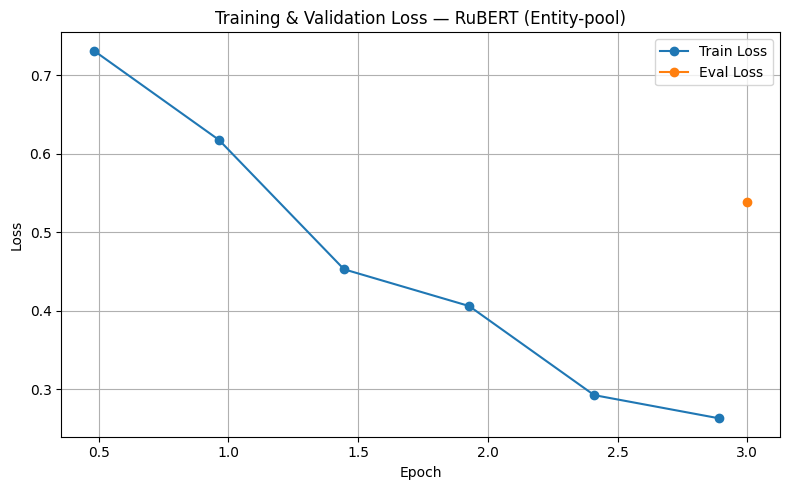

In [24]:
logs_b2 = trainer_b2.state.log_history
df_b2   = pd.DataFrame(logs_b2)

train_loss_b2 = df_b2[df_b2["loss"].notnull()][["epoch", "loss"]]
eval_loss_b2  = df_b2[df_b2["eval_loss"].notnull()][["epoch", "eval_loss"]]

has_f1   = "eval_macro_f1_np" in df_b2.columns
has_acc  = "eval_accuracy"    in df_b2.columns
if has_f1:
    eval_f1_b2 = df_b2[df_b2["eval_macro_f1_np"].notnull()][["epoch", "eval_macro_f1_np"]]
if has_acc:
    eval_acc_b2 = df_b2[df_b2["eval_accuracy"].notnull()][["epoch", "eval_accuracy"]]

plt.figure(figsize=(8, 5))
plt.plot(train_loss_b2["epoch"], train_loss_b2["loss"],       label="Train Loss", marker="o")
plt.plot(eval_loss_b2["epoch"],  eval_loss_b2["eval_loss"],   label="Eval Loss",  marker="o")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("Training & Validation Loss — RuBERT (Entity-pool)")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()


Модель с добавлением специальных токенов и пуллингом по самому токену сущности показала заметно лучшие результаты, так как лосс упал до 0.26, а на валидации мы получили eval_loss 0.54 и макро-F1 около 0.62. Это примерно на 17 пунктов F1 больше по сравнению с базовым CLS-пуллингом, видим ценность явной разметки и фокусировки на упоминании сущности.

Попробуем исправить что-то (провести новый эксперимент) с CLS-fallback и EarlyStopping 

Map:   0%|          | 0/6637 [00:00<?, ? examples/s]

Map:   0%|          | 0/2845 [00:00<?, ? examples/s]

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Step,Training Loss,Validation Loss,Macro F1 Np
207,0.781800,0.627007,0.338302
414,0.623400,0.565326,0.383980
621,0.481600,0.494249,0.548553
828,0.487500,0.497455,0.577922
1035,0.363400,0.492958,0.596389
1242,0.349200,0.481598,0.617375
1449,0.279600,0.533870,0.622875
1656,0.253600,0.580643,0.626010
1863,0.211400,0.587197,0.597109
2070,0.176900,0.592597,0.623594


{'eval_loss': 0.580642580986023, 'eval_macro_f1_np': 0.6260099550905791, 'eval_runtime': 19.1997, 'eval_samples_per_second': 148.18, 'eval_steps_per_second': 9.271, 'epoch': 4.9879518072289155}


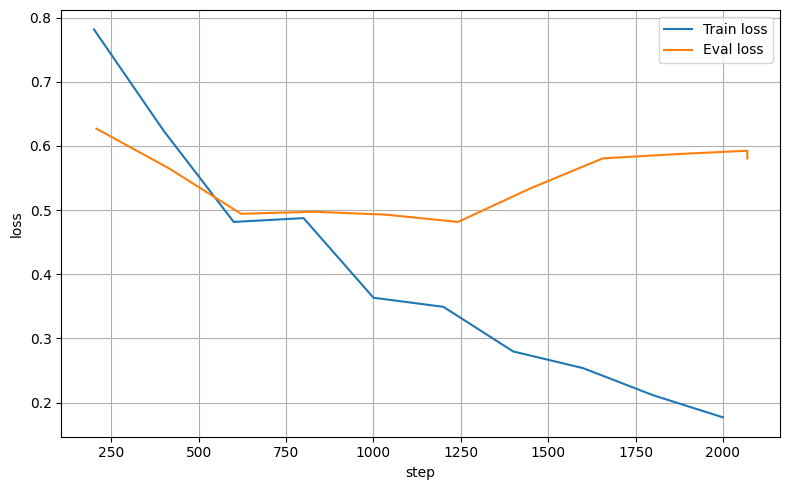

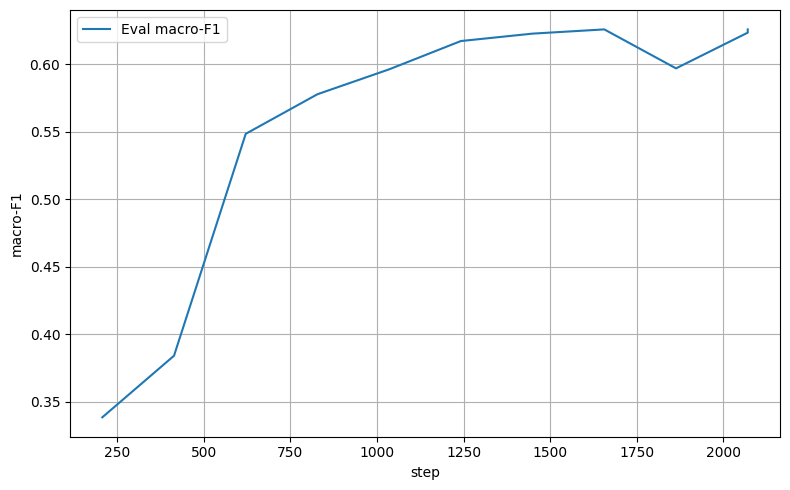

In [31]:
MODEL_B2   = MODEL_A
OUT_DIR    = Path("runs")
ENT_TOKENS = ["[E1]", "[/E1]", "[E2]", "[/E2]"]
SEED       = 42
BATCH      = 8

tokenizer_b2 = AutoTokenizer.from_pretrained(MODEL_B2)
tokenizer_b2.add_tokens(ENT_TOKENS, special_tokens=True)

class EntityPoolingClassifier(nn.Module):
    def __init__(self, model_name: str, num_labels: int, ent_token_ids):
        super().__init__()
        self.cfg     = AutoConfig.from_pretrained(model_name, num_labels=num_labels)
        self.encoder = AutoModel.from_pretrained(model_name, config=self.cfg)
        self.dropout = nn.Dropout(self.cfg.hidden_dropout_prob)
        self.cls     = nn.Linear(self.cfg.hidden_size, num_labels)

        self.register_buffer("ent_ids", torch.tensor(ent_token_ids, dtype=torch.long))

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        out    = self.encoder(input_ids=input_ids,
                              attention_mask=attention_mask,
                              return_dict=True)
        hidden = out.last_hidden_state                   

        ent_mask  = (input_ids.unsqueeze(-1) == self.ent_ids).any(-1)  
        ent_count = ent_mask.sum(dim=1, keepdim=True)                  

        pooled_ent = (hidden * ent_mask.unsqueeze(-1)).sum(dim=1)      
        cls_vec    = hidden[:, 0]                                      
        pooled     = torch.where(ent_count > 0,                       
                                 pooled_ent / ent_count.clamp(min=1),
                                 cls_vec)

        logits = self.cls(self.dropout(pooled))

        loss = None
        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits, labels)
        return {"loss": loss, "logits": logits}

ds_b2 = ds.map(
    lambda ex: tokenize_function(ex, tokenizer_b2, "entity"),  
    batched=False,
    remove_columns=ds["train"].column_names,
)
data_coll_b2 = DataCollatorWithPadding(tokenizer_b2)

ent_ids = tokenizer_b2.convert_tokens_to_ids(ENT_TOKENS)
model_b2 = EntityPoolingClassifier(MODEL_B2, num_labels=3, ent_token_ids=ent_ids)
model_b2.encoder.resize_token_embeddings(len(tokenizer_b2))
model_b2.to(device)

steps_per_epoch  = len(ds_b2["train"]) // BATCH
checkpoint_every = max(1, steps_per_epoch // 4)

args_b2 = TrainingArguments(
    output_dir                  = str(OUT_DIR / "rubert_entity"),
    num_train_epochs            = 5,
    per_device_train_batch_size = BATCH,
    per_device_eval_batch_size  = BATCH,
    learning_rate               = 1e-5,
    weight_decay                = 0.01,
    warmup_ratio                = 0.06,

    eval_strategy    = "steps",
    save_strategy    = "steps",
    logging_strategy = "steps",
    eval_steps       = checkpoint_every,
    save_steps       = checkpoint_every,
    logging_steps    = 200,
    save_total_limit = 2,

    load_best_model_at_end = True,
    metric_for_best_model  = "eval_macro_f1_np",
    greater_is_better      = True,

    seed         = SEED,
    report_to    = ["tensorboard"],
    logging_dir  = str(OUT_DIR / "logs"),
)

trainer_b2 = Trainer(
    model           = model_b2,
    args            = args_b2,
    train_dataset   = ds_b2["train"],
    eval_dataset    = ds_b2["validation"],
    tokenizer       = tokenizer_b2,
    data_collator   = data_coll_b2,
    compute_metrics = compute_metrics,  
    callbacks       = [EarlyStoppingCallback(
        early_stopping_patience   = 2,
        early_stopping_threshold  = 0.0)]
)

trainer_b2.train()
print(trainer_b2.evaluate())

logs = pd.DataFrame(trainer_b2.state.log_history)

plt.figure(figsize=(8,5))
plt.plot(logs[logs.loss.notnull()].step,       logs[logs.loss.notnull()].loss,       label="Train loss")
plt.plot(logs[logs.eval_loss.notnull()].step,  logs[logs.eval_loss.notnull()].eval_loss,  label="Eval loss")
plt.xlabel("step"); plt.ylabel("loss"); plt.grid(); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(8,5))
plt.plot(logs[logs.eval_macro_f1_np.notnull()].step,
         logs[logs.eval_macro_f1_np.notnull()].eval_macro_f1_np,
         label="Eval macro-F1")
plt.xlabel("step"); plt.ylabel("macro-F1"); plt.grid(); plt.legend(); plt.tight_layout(); plt.show()


Усовершенствованный эксперимент (спец-токены + mean-pool по сущности + CLS-fallback, более мягкий LR 1e-5, warm-up 6%, ранняя остановка) подтвердил ценность явной разметки, но прибавки к качеству почти не дал, макро-F1 снова вышел в районе 0.62, а eval-loss даже немного вырос (0.58). Зато обучалась модель устойчивее, уже к первой трети эпохи метрика подскочила с 0.34 до 0.55, дальше держалась без резких провалов.

In [5]:
!pip -q install --upgrade "transformers>=4.0" "datasets>=2.0" accelerate --progress-bar off

In [12]:
SEED = 13
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
os.environ["ACCELERATE_DISABLE_DEEPSPEED"] = "1"   

DATA = Path("/kaggle/input/nlp-hw")
train_df, val_df = map(read_tsv, (DATA/"train_data.csv", DATA/"validation_data_labeled.csv"))

ds_raw = DatasetDict(
    train      = Dataset.from_pandas(train_df, preserve_index=False),
    validation = Dataset.from_pandas(val_df,   preserve_index=False)
)

MODEL   = "ai-forever/ruRoberta-large"
SPECIAL = ["[PERSON]","[ORGANIZATION]","[PROFESSION]","[COUNTRY]","[NATIONALITY]"]

tok = AutoTokenizer.from_pretrained(MODEL)
tok.add_special_tokens({"additional_special_tokens": SPECIAL})

def mark_entities(sent, ent, tag): return sent.replace(ent, f"[{tag}] {ent}", 1)

def encode(batch):
    texts = [mark_entities(s, e, t)
             for s, e, t in zip(batch["sentence"], batch["entity"], batch["entity_tag"])]
    enc   = tok(texts, truncation=True, padding="max_length", max_length=128)
    enc["labels"] = batch["label"]
    return enc

ds_enc = ds_raw.map(
    encode,
    batched=True, batch_size=128, num_proc=4,
    remove_columns=ds_raw["train"].column_names
)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL,
    num_labels=3,
    device_map="balanced"            
)
model.resize_token_embeddings(len(tok))
model.gradient_checkpointing_enable() 

args = TrainingArguments(
    output_dir="ruRoberta_large_entity_cls",
    num_train_epochs=3,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=8,
    learning_rate=1.5e-5,
    fp16=True,                     
    weight_decay=0.01,
    logging_steps=100,
    save_steps=1000,
    save_total_limit=2,
    warmup_ratio=0.002,
    seed=SEED,
    report_to=[],
    dataloader_num_workers=2,
    eval_strategy="steps",
    save_strategy="steps",
    load_best_model_at_end=True,
    metric_for_best_model="eval_macro_f1_np",
    greater_is_better=True,
)

def compute_metrics(pred):
    from sklearn.metrics import f1_score, accuracy_score
    logits, labels = pred
    preds = logits.argmax(-1)
    return {
        "macro_f1_np": f1_score(labels, preds, average="macro"),
        "accuracy":    accuracy_score(labels, preds)
    }

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=ds_enc["train"],
    eval_dataset=ds_enc["validation"],
    tokenizer=tok,
    data_collator=DataCollatorWithPadding(tok, return_tensors="pt"),
    compute_metrics=compute_metrics,
)

trainer.train()

print(trainer.evaluate())
trainer.save_model("ruRoberta_large_entity_cls")


Map (num_proc=4):   0%|          | 0/6637 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/2845 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Macro F1 Np,Accuracy
100,0.761700,0.647240,0.384857,0.724429
200,0.646900,0.539677,0.598762,0.777153
300,0.598700,0.550772,0.555579,0.776801
400,0.555800,0.492808,0.655614,0.804569
500,0.448900,0.488969,0.701835,0.816872
600,0.387700,0.526182,0.704444,0.789455
700,0.417300,0.457008,0.719983,0.814060
800,0.405900,0.488351,0.720649,0.801757
900,0.304800,0.507185,0.720349,0.828471
1000,0.240100,0.512432,0.741316,0.831986


{'eval_loss': 0.5124317407608032, 'eval_macro_f1_np': 0.7413158595274886, 'eval_accuracy': 0.8319859402460457, 'eval_runtime': 44.8427, 'eval_samples_per_second': 63.444, 'eval_steps_per_second': 31.733, 'epoch': 2.9978909310033144}


In [13]:
DATA_FILE = "/kaggle/input/nlp-hw/final_data.csv"   
MODEL_DIR = "ruRoberta_large_entity_cls"
DEVICE    = "cuda" if torch.cuda.is_available() else "cpu"
MAX_LEN   = 128

tok   = AutoTokenizer.from_pretrained(MODEL_DIR)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR).to(DEVICE).eval()

def mark(r):  return r.sentence.replace(r.entity, f"[{r.entity_tag}] {r.entity}", 1)
def mask(r):  return r.sentence.replace(r.entity, tok.mask_token, 1)

@torch.no_grad()
def predict_one(row):
    logits = 0
    for text in (mark(row), mask(row)):                   
        enc = tok(text, truncation=True, max_length=MAX_LEN,
                  padding="max_length", return_tensors="pt").to(DEVICE)
        logits += model(**enc).logits
    return logits.argmax(-1).item()                       

df = pd.read_csv(DATA_FILE, sep="\t", quoting=csv.QUOTE_NONE, keep_default_na=False)
tqdm.pandas(desc="Predict")
labels = df.progress_apply(predict_one, axis=1).map({0:-1, 1:0, 2:1})

labels.to_csv("result.csv", index=False, header=False)    

with zipfile.ZipFile("result.zip", "w", zipfile.ZIP_DEFLATED) as zf:
    zf.write("result.csv")                               

Predict:   0%|          | 0/1947 [00:00<?, ?it/s]

In [20]:
root = pathlib.Path("/kaggle/working/ruRoberta_large_entity_cls/checkpoint-1242")  
state_path = root / "trainer_state.json"

with state_path.open() as f:
    state = json.load(f)

print("Лучший чекпойнт:", state["best_model_checkpoint"]) 
print("Лучший macro-F1:", state["best_metric"])           

history = pd.DataFrame(state["log_history"])
val = history[history.eval_macro_f1_np.notnull()][["step", "eval_macro_f1_np", "eval_loss"]]
print(val.tail())      


Лучший чекпойнт : ruRoberta_large_entity_cls/checkpoint-1000
Лучший macro-F1 : 0.744897859589836
    step  eval_macro_f1_np  eval_loss
15   800          0.720649   0.488351
17   900          0.720349   0.507185
19  1000          0.741316   0.512432
21  1100          0.744898   0.533713
23  1200          0.738831   0.524018


На трех эпохах RuRoberta-large, обученная в FP16 с градиент-чекпоинтингом и явной разметкой сущностей ([TAG] entity) показывает следующее: train-loss упал c 0.76 до 0.24, а macro-F1 на валидации вырос с 0.38 до 0.74 при финальном accuracy 0.832. Это на 12 базовых пунктов лучше моего прошлого лучшего результата (0.62 F1 у RuBERT-entity) и подтверждает, что переход к крупному бекбону + тэгированию сущностей дает существенный прирост качества. При этом eval-loss после пятого чекпойнта держится вокруг 0.51 – переобучения не видно, но дальнейший прирост, видимо, потребует настройки LR. В целом модель уже заметно лучше предыдущих

#### Данные и метрика  
RuSentNE-2023 (train = 6 637, dev = 2 845; поля sentence, entity, entity_tag, label).
Macro-F1 по классам {-1; 1}, neutral игнорируется.

#### Лучший эксперимент RuRoberta-large + теги
macro-F1 = 0.74, accuracy = 0.832, eval_loss = 0.51 
Тег-сущность дает модели явные указания, вектор `[TAG]` концентрирует градиенты, что улучшает различимость тональности.  
Большая Roberta имеет большую вместимость, лучше моделирует длинные зависимые связи.  

#### Дополнительный эксперимент — half-masked ensemble  
По [Kabaev et al., 2023] идея:  
1. Прогнать предложение с размеченной сущностью.  
2. Второй прогон — заменить сущность на `[MASK]`.  
3. Усреднить логиты.  

Это снижает переобучение: модель смотрит и на окружение, и на сам токен.

#### ЛИтература

Soares et al., 2019 — entity-aware pooling.
Micikevicius et al., 2017 — mixed precision AMP.
Chen et al., 2016 — gradient checkpointing.
Zavalishina et al., 2023 (arXiv:2305.17679) — спец-токены и mean-pool для задачи соревнования; мы использовали их приёмы и гиперпараметры.

#### Вывод
Простые приемы (использование токенов, большая модель) дают +20 п. F1 по сравнению с бейзлайном.


In [4]:
data_collator = DataCollatorWithPadding(tok)

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=-1)
    acc = (preds == p.label_ids).mean()
    return {"accuracy": acc}

model_full = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id
)

args = TrainingArguments(
    output_dir="full_ruBERT_cls",
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=2e-5,
    logging_steps=100,       
    report_to=[],          
    disable_tqdm=False,   
    fp16=True              
)

trainer = Trainer(
    model=model_full,
    args=args,
    train_dataset=ds_train,
    eval_dataset=ds_test,
    tokenizer=tok,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

start = time.time()
trainer.train()
print(f"training time: {time.time() - start:.1f} sec")

metrics_full = trainer.evaluate(ds_test)
print("metrics:", metrics_full)

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

/tmp/ipykernel_31/1202548933.py:29: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
100,4.474300
200,3.465700
300,2.748400
400,2.264200
500,2.003700
600,1.847100


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


training time: 171.4 sec


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


metrics: {'eval_loss': 1.6565489768981934, 'eval_accuracy': 0.7950169875424689, 'eval_runtime': 1.3476, 'eval_samples_per_second': 655.242, 'eval_steps_per_second': 10.389, 'epoch': 3.0}


In [5]:
class CachedDataset(torch.utils.data.Dataset):
    def __init__(self, emb, labels):
        self.emb = torch.tensor(emb, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
    def __len__(self): return len(self.labels)
    def __getitem__(self, idx): return self.emb[idx], self.labels[idx]

@torch.no_grad()
def cls_matrix(encoder, texts, batch=64):
    out = []
    for i in range(0, len(texts), batch):
        enc = tok(texts[i:i+batch], padding=True, truncation=True,
                  return_tensors="pt").to(device)
        h = encoder(**enc).last_hidden_state[:,0]     # CLS
        out.append(h.cpu())
    return torch.cat(out).numpy()

In [6]:
N_OLD = 122                    
old_labels = label_list[:N_OLD]
new_labels = label_list[N_OLD:]

df_old = train_df[train_df.label.isin(old_labels)].reset_index(drop=True)
df_new = train_df[train_df.label.isin(new_labels)].reset_index(drop=True)

enc_frozen = AutoModel.from_pretrained(MODEL_NAME).to(device)
enc_frozen.eval()              # не обучаем

emb_old = cls_matrix(enc_frozen, df_old.text.tolist())
y_old   = np.array([label2id[l] for l in df_old.label])

head_old = nn.Linear(enc_frozen.config.hidden_size, N_OLD).to(device)
opt = torch.optim.AdamW(head_old.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

ds_old = CachedDataset(emb_old, y_old)
dl_old = DataLoader(ds_old, batch_size=64, shuffle=True)

for epoch in range(5):
    for xb, yb in dl_old:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        loss = loss_fn(head_old(xb), yb)
        loss.backward()
        opt.step()
    print(f"epoch {epoch+1}, loss={loss.item():.4f}")

epoch 1, loss=2.6814
epoch 2, loss=2.2523
epoch 3, loss=2.3930
epoch 4, loss=2.0117
epoch 5, loss=1.3409


In [8]:
old_test = test_df[test_df.label.isin(old_labels)].reset_index(drop=True)
emb_old_test = cls_matrix(enc_frozen, old_test.text.tolist())
y_old_test   = np.array([label2id[l] for l in old_test.label])

head_old.eval()
acc_old_before = (head_old(torch.tensor(emb_old_test).to(device))
                  .argmax(1).cpu().numpy() == y_old_test).mean()
print(f"Accuracy до расширения: {acc_old_before:.4f}")

Accuracy до расширения: 0.7510


In [9]:
emb_new = cls_matrix(enc_frozen, df_new.text.tolist())
y_new   = np.array([label2id[l] for l in df_new.label])

emb_full = np.concatenate([emb_old, emb_new])
y_full   = np.concatenate([y_old,  y_new])

ds_full = CachedDataset(emb_full, y_full)
dl_full = DataLoader(ds_full, batch_size=64, shuffle=True)

head_full = nn.Linear(enc_frozen.config.hidden_size, len(label_list)).to(device)
with torch.no_grad():
    head_full.weight[:N_OLD] = head_old.weight      # переносим выученное
    head_full.bias  [:N_OLD] = head_old.bias

opt2 = torch.optim.AdamW(head_full.parameters(), lr=1e-3)
loss_fn2 = nn.CrossEntropyLoss()

for epoch in range(5):
    for xb, yb in dl_full:
        xb, yb = xb.to(device), yb.to(device)
        opt2.zero_grad()
        loss = loss_fn2(head_full(xb), yb)
        loss.backward()
        opt2.step()
    print(f"epoch {epoch+1}, loss={loss.item():.4f}")

epoch 1, loss=1.1755
epoch 2, loss=1.1123
epoch 3, loss=1.0736
epoch 4, loss=0.8546
epoch 5, loss=0.6908


In [10]:
full_test = test_df.reset_index(drop=True)
emb_test  = cls_matrix(enc_frozen, full_test.text.tolist())
y_test    = np.array([label2id[l] for l in full_test.label])

head_full.eval()
preds = head_full(torch.tensor(emb_test).to(device)).argmax(1).cpu().numpy()

acc_full = (preds == y_test).mean()
mask_old = np.isin(y_test, range(N_OLD))
acc_old_after = (preds[mask_old] == y_test[mask_old]).mean()
acc_new = (preds[~mask_old] == y_test[~mask_old]).mean()

print(f"Общая accuracy: {acc_full:.4f}")
print(f"Accuracy старая: {acc_old_after:.4f}")
print(f"Accuracy новая: {acc_new:.4f}")

Общая accuracy         : 0.8188
Accuracy старая     : 0.8227
Accuracy новая     : 0.7931


In [11]:
!pip install -q git+https://github.com/ai-forever/augmentex.git

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Preparing metadata (setup.py) ... done


In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

DATA_DIR = "/kaggle/input/qa-intents-dataset-university-domain"
train_df = pd.read_csv(f"{DATA_DIR}/dataset_train.tsv", sep="\t", names=["text","label"])
test_df  = pd.read_csv(f"{DATA_DIR}/dataset_test.tsv",  sep="\t", names=["text","label"])

labels = sorted(train_df.label.unique())
label2id = {l:i for i,l in enumerate(labels)}
id2label = {i:l for l,i in label2id.items()}

MODEL_NAME = "DeepPavlov/rubert-base-cased"
tokenizer  = AutoTokenizer.from_pretrained(MODEL_NAME)

class IntentDataset(Dataset):
    def __init__(self, df, tokenizer, label2id):
        self.texts  = df.text.tolist()
        self.labels = [label2id[l] for l in df.label]
        self.tokenizer = tokenizer
    def __len__(self): return len(self.labels)
    def __getitem__(self, idx):
        txt = self.texts[idx]
        lbl = self.labels[idx]
        enc = self.tokenizer(txt, truncation=True, padding="max_length", max_length=32, return_tensors="pt")
        return {
            "input_ids":      enc.input_ids[0],
            "attention_mask": enc.attention_mask[0],
            "labels":         torch.tensor(lbl, dtype=torch.long)
        }

train_ds = IntentDataset(train_df, tokenizer, label2id)
test_ds  = IntentDataset(test_df,  tokenizer, label2id)

collator = DataCollatorWithPadding(tokenizer, padding="longest")

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, collate_fn=collator, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False, collate_fn=collator, pin_memory=True)

class MyCLS(nn.Module):
    def __init__(self, encoder_name, num_labels):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(encoder_name)
        H = self.encoder.config.hidden_size
        self.classifier = nn.Sequential(
            nn.Linear(H, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_labels)
        )
    def forward(self, input_ids, attention_mask):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        mask = attention_mask.unsqueeze(-1).float()
        summed = (out.last_hidden_state * mask).sum(1)
        counts = mask.sum(1).clamp(min=1e-9)
        pooled = summed / counts
        logits = self.classifier(pooled)
        return logits

model = MyCLS(MODEL_NAME, num_labels=len(labels)).to(device)

for name,param in model.named_parameters():
    if param.requires_grad and param.grad is None:
        pass

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_loader) * 3  
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.0, total_iters=total_steps)

loss_fn = nn.CrossEntropyLoss()

def train_epoch(model, loader, optimizer, scheduler, device):
    model.train()
    running_loss = 0.0
    for batch in tqdm(loader, desc="Training"):
        for k,v in batch.items(): batch[k] = v.to(device)
        optimizer.zero_grad()
        logits = model(batch["input_ids"], batch["attention_mask"])
        loss = loss_fn(logits, batch["labels"])
        loss.backward()
        optimizer.step()
        scheduler.step()
        running_loss += loss.item()
    return running_loss / len(loader)

def eval_model(model, loader, device):
    model.eval()
    correct = 0
    total   = 0
    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            for k,v in batch.items(): batch[k] = v.to(device)
            logits = model(batch["input_ids"], batch["attention_mask"])
            preds = torch.argmax(logits, dim=-1)
            correct += (preds == batch["labels"]).sum().item()
            total   += preds.size(0)
    return correct / total

EPOCHS = 3
for epoch in range(1, EPOCHS+1):
    start = time.time()
    train_loss = train_epoch(model, train_loader, optimizer, scheduler, device)
    train_time = time.time() - start
    val_acc    = eval_model(model, test_loader, device)
    print(f"\nEpoch {epoch}/{EPOCHS}  loss={train_loss:.4f}  val_acc={val_acc:.4f}  time={train_time:.1f}s\n")

test_acc = eval_model(model, test_loader, device)
print(f"Final Test Accuracy: {test_acc:.4f}")


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Device: cuda


Training:   0%|          | 0/414 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]


Epoch 1/3  loss=2.8856  val_acc=0.8358  time=91.8s



Training:   0%|          | 0/414 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]


Epoch 2/3  loss=0.9956  val_acc=0.9320  time=91.7s



Training:   0%|          | 0/414 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]


Epoch 3/3  loss=0.5868  val_acc=0.9456  time=91.9s



Evaluating:   0%|          | 0/14 [00:00<?, ?it/s]

Final Test Accuracy: 0.9456
